# Importing main packages

In [1]:
import os
import numpy as np
import scipy as sc
from scipy import signal
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd

%matplotlib inline
from scipy.io import loadmat
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

import os

!pip install biosppy
!pip install pyhrv
!pip install neurokit2
!pip install hrv
!pip install heartpy
!pip install neurokit

import heartpy
import biosppy
import neurokit2 as nk
import hrv
import pyhrv
import matplotlib.gridspec as gridspec


# Warning

When loading hrv, an ImportError may arise. It will be corrected by doing the following:   
* Go to your local environment at anaconda3 and search the folder site-packages/hrv.    
* Open the file rri.py and change the following line:    
from collections import MutableMapping, defaultdict    
* by the following lines    
from collections.abc import MutableMapping    
from collections import defaultdict     

# Preprocessing part

We aim to obtain all the signals. We have 550 signals associated to training and 250 associated to test.

(0.0, 50.0)

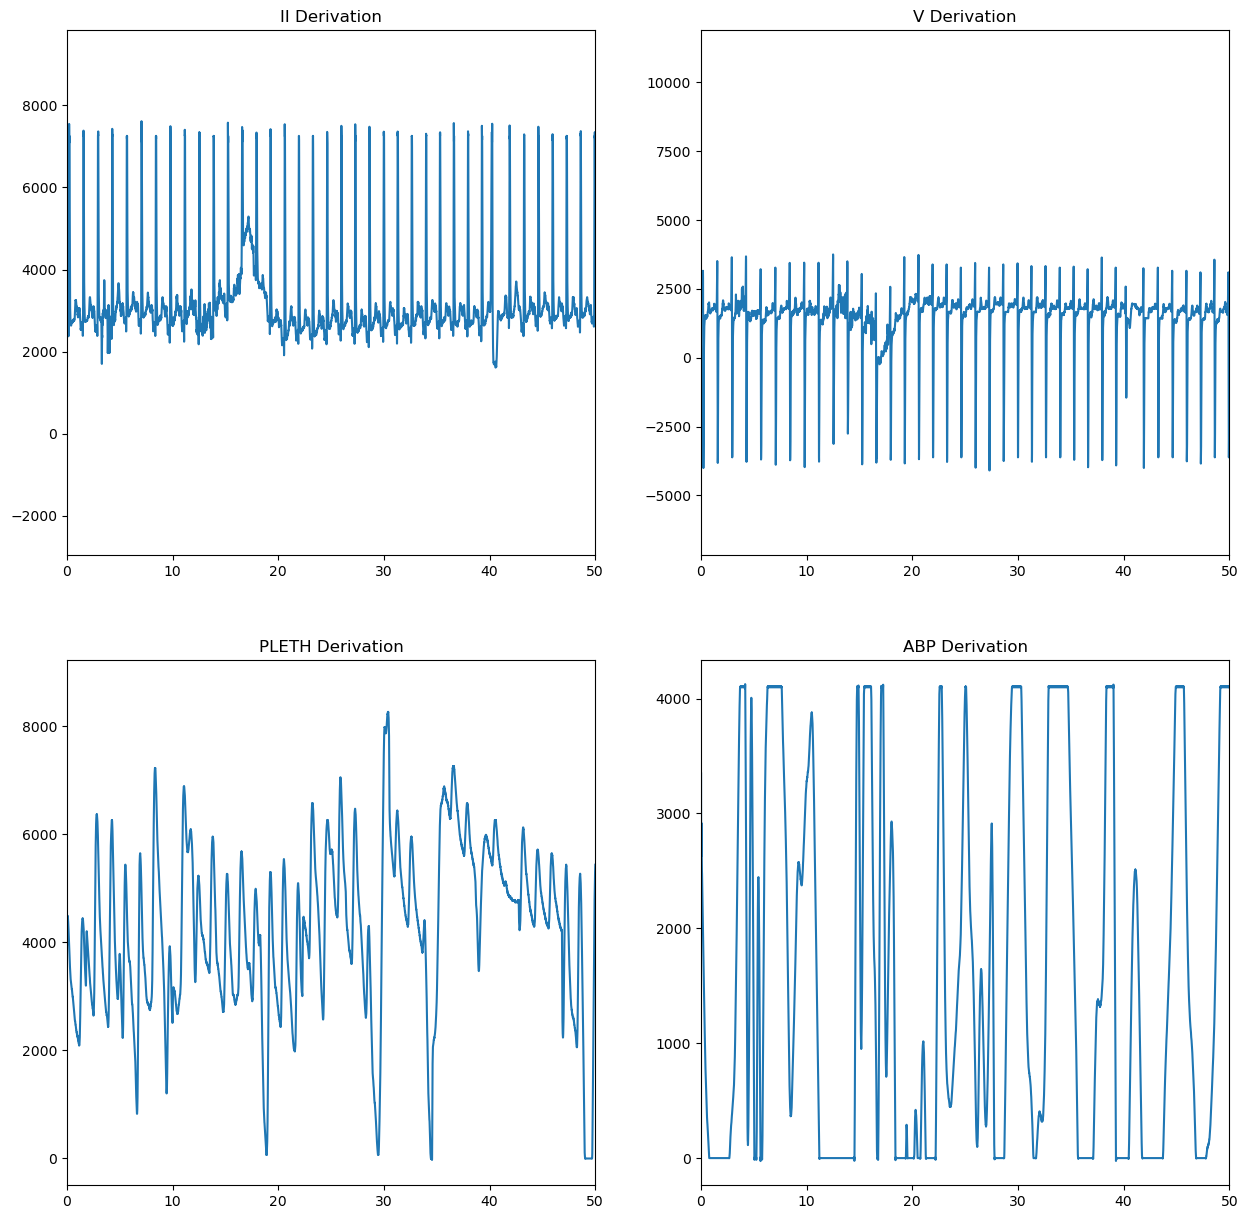

In [2]:
path = '/home/aitorchagon/Desktop/Proyectos/ICU-false-alarm-detection/physiological-signals-processing-challenge-2021/data_challenge/training/'

names_list = []
for i in range(1, 551):
    pat_filename = '{}.hea'.format(i)
    names_list.append(pat_filename)
signals_list = []
for elem in names_list:
    pat = loadmat(os.path.join(path, elem[:-4] + '.mat')) # reading the signals' file.
    signals_list.append(pat)

for elem in signals_list:
    elem = sc.signal.resample(elem['val'], 125) #resampling to 125 Hz.

#plotting a sample 
t = np.arange(0, 75000)/125
plt.figure(figsize = (15, 15))
plt.subplot(221)
plt.plot(t, signals_list[1]['val'][0,:75000])
plt.title('II Derivation')
plt.xlim(0, 50)
plt.subplot(222)
plt.plot(t, signals_list[1]['val'][1,:75000])
plt.title('V Derivation')
plt.xlim(0, 50)
plt.subplot(223)
plt.plot(t, signals_list[1]['val'][2, :75000])
plt.title('PLETH Derivation')
plt.xlim(0, 50)
plt.subplot(224)
plt.plot(t, signals_list[1]['val'][3, :75000])
plt.title('ABP Derivation')
plt.xlim(0, 50)


Now, we will proceed to filter our signal to remove typical noises.

(0.0, 50.0)

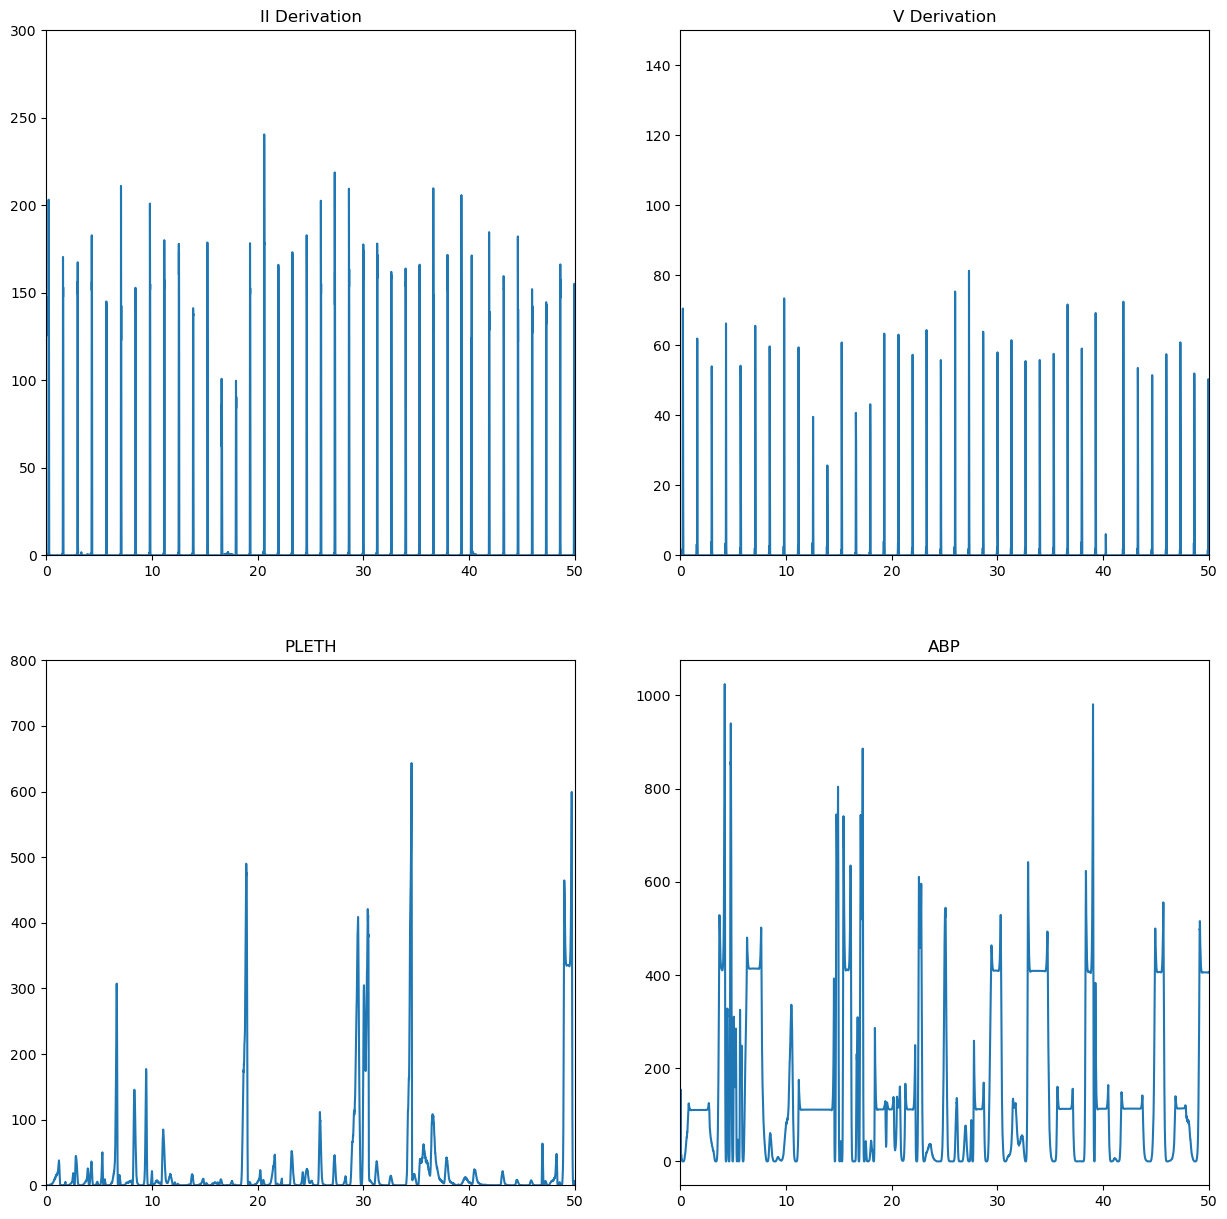

In [3]:
# We apply a low-pass filter (IIR notch) at 50 Hz to remove streamline voltage.
b, a= sc.signal.iirnotch(38, fs = 125, Q = 30)
# We apply a pass-band filter at 0.5-40Hz to remove baseline wander (and EMG noise)
c = sc.signal.firwin(64, [0.5, 40], pass_zero = False, fs=125, window='hamming')

filtered_dataframe = pd.DataFrame()
II_filtered_list = []
V_filtered_list = []
ABP_filtered_list = []
PLETH_filtered_list = []
for i in range (551):
    try: #removing linear tendency and improving peaks, avoiding clipping on our signals.
        elem1 = sc.signal.filtfilt(b, a, signals_list[i]['val'][0, :75000])
        elem1 = sc.signal.filtfilt(c, 1, elem1)
        elem1[np.isnan(elem1)] = 0.00001
        elem1 = sc.signal.detrend(elem1)
        elem1 = heartpy.enhance_peaks(elem1, iterations = 2)
        II_filtered_list.append(elem1)
        elem2 = sc.signal.filtfilt(b, a, signals_list[i]['val'][1, :75000])
        elem2 = sc.signal.filtfilt(c, 1, elem2)
        elem2[np.isnan(elem2)] = 0.00001
        elem2 = sc.signal.detrend(elem2)
        elem2 = heartpy.enhance_peaks(elem2, iterations = 2)
        V_filtered_list.append(elem2)
        elem3 = sc.signal.filtfilt(b, a, signals_list[i]['val'][2, :75000])
        elem3 = sc.signal.filtfilt(c,1, elem3)
        elem3[np.isnan(elem3)] = 0.00001
        elem3 = sc.signal.detrend(elem3)
        elem3 = heartpy.enhance_peaks(elem3, iterations = 2)
        PLETH_filtered_list.append(elem3)
        elem4 = sc.signal.filtfilt(b, a, signals_list[i]['val'][3, :75000])
        elem4 = sc.signal.filtfilt(c, 1, elem4)
        elem4[np.isnan(elem4)] = 0.00001
        elem4 = sc.signal.detrend(elem4)
        elem4 = heartpy.enhance_peaks(elem4, iterations = 2)
        ABP_filtered_list.append(elem4)
    except IndexError:
        continue
    # IndexError appears as a result of the dataset; not all patients have a PLETH or ABP signal channel.

gs = gridspec.GridSpec(2, 2)
t = np.arange(0, 75000)/125
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1.plot(t, II_filtered_list[1])
plt.title('II Derivation')
plt.xlim(0, 50)
plt.ylim(0, 300)
ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax2.plot(t, V_filtered_list[1])
plt.title('V Derivation')
plt.xlim(0, 50)
plt.ylim(0, 150)
ax3 = fig.add_subplot(gs[1, 0]) # row 1, col 0
ax3.plot(t, PLETH_filtered_list[1])
plt.title('PLETH')
plt.xlim(0, 50)
plt.ylim(0, 800)
ax4 = fig.add_subplot(gs[1, 1]) # row 1, col 1
ax4.plot(t, ABP_filtered_list[1])
plt.title('ABP')
plt.xlim(0, 50)

# Feature acquisition part

We are going to work with:   
* Spectral purity index (SPI)    
* PLETH/ABP quality.    
* HR average, PLETH/ABP decrease (OSc-ANFc-W)   
* Max HR intervals (AMM)   
* Linear Discriminant Analysis (LDA)   
* Average and median of PLETH/ABP (OSc-ANFc-W)   
* Min HR at 5 consecutive beats   
* Average and median of ECG   
* Max average HR in windows of 3 seconds (OSc-ANFc-W) of PLETH/ABP    
* Min average HR in windows of 3 seconds (OSc-ANFc-W) of PLETH/ABP    
* SPI (averaged and max) at ECG    
* Max averaged SPI in windows of 3 seconds.   

In [26]:
def getting_properties(entry: np.array):
    rpeaks = []
    rr_interval = []
    properties = []
    for index, value in enumerate(entry):
        rpeaks_init, _ = sc.signal.find_peaks(entry[index], distance = 150)
        rpeaks_init = biosppy.signals.ecg.correct_rpeaks(entry[index], rpeaks = rpeaks_init, sampling_rate = 125, tol = 0.04)
        rr_interval_init = np.diff(rpeaks_init)/125 * 1000
        rpeaks.append(rpeaks_init[0])
        rr_interval.append(rr_interval_init)
        rpeaksV, propertiesV = sc.signal.find_peaks(entry[index], distance = 150, prominence = 1, width = 20)
        properties.append(propertiesV["width_heights"]) # width of the peak, relative to baseline; the width is 
        # normally narrower if there are more beats per second.
        return rpeaks, properties, rr_interval

In [27]:
# Obtaining R peaks of ECG signals and RR intervals.
rpeaks_V, properties_V, rr_interval_V = getting_properties(V_filtered_list)
rpeaksII, properties_II, rr_interval_II = getting_properties(II_filtered_list)

print(rpeaks_V, rr_interval_II)

[array([  104,   273,   440,   610,   779,   947,  1114,  1282,  1451,
        1619,  1785,  1952,  2119,  2285,  2450,  2619,  2787,  2954,
        3122,  3289,  3455,  3619,  3788,  3955,  4121,  4289,  4455,
        4620,  4787,  4954,  5120,  5286,  5453,  5619,  5786,  5956,
        6124,  6292,  6461,  6632,  6802,  6973,  7145,  7319,  7489,
        7660,  7833,  8005,  8176,  8348,  8521,  8693,  8863,  9036,
        9207,  9377,  9546,  9718,  9887, 10057, 10226, 10397, 10567,
       10738, 10909, 11081, 11251, 11422, 11594, 11767, 11937, 12107,
       12281, 12455, 12625, 12798, 12971, 13147, 13320, 13493, 13666,
       13842, 14016, 14188, 14360, 14534, 14709, 14881, 15052, 15225,
       15399, 15571, 15744, 15917, 16090, 16263, 16434, 16609, 16783,
       16956, 17127, 17298, 17470, 17642, 17811, 17980, 18150, 18320,
       18491, 18661, 18830, 19000, 19172, 19341, 19508, 19676, 19845,
       20012, 20178, 20347, 20516, 20681, 20847, 21016, 21185, 21351,
       21518, 21686

'\nfor index, value in enumerate(V_filtered_list):\n    rpeaksV, _ = sc.signal.find_peaks(V_filtered_list[index], distance = 150)\n    rpeaksV = biosppy.signals.ecg.correct_rpeaks(V_filtered_list[index], rpeaks = rpeaksV, sampling_rate = 125, tol = 0.04)\n    rr_intervalV = np.diff(rpeaksV)/125 * 1000\n    rpeaks_V.append(rpeaksV[\'rpeaks\'])\n    rr_interval_V.append(rr_intervalV)\n    rpeaksV, propertiesV = sc.signal.find_peaks(V_filtered_list[index], distance = 150, prominence = 1, width = 20)\n    properties_V.append(propertiesV["width_heights"]) # width of the peak, relative to baseline; the width is \n    # normally narrower if there are more beats per second.\n    properties_V.append(propertiesV["prominences"]) # height of the peak, relative to baseline\nfor index, value in enumerate(II_filtered_list):\n    rpeaksII, _ = sc.signal.find_peaks(II_filtered_list[index], distance = 150)\n    rpeaksII = biosppy.signals.ecg.correct_rpeaks(II_filtered_list[index], rpeaks = rpeaksII, sam

In [ ]:
# Main statistics: average, median, max amplitude,
# quasi-variance, standard deviation, absolute deviation kurtosis, skewness

#Use a dictionary to make this fragment of code shorter and more elegantenumerate
averageV = []
medianV = []
maxamplitudeV = [] 
quasivarV = []
stdV = []
stdabsV = [] 
kurtV = []
skewV = []
averageII = []
medianII = []
maxamplitudeII = [] 
quasivarII = []
stdII = []
stdabsII = [] 
kurtII = []
skewII = []
averagePLETH = []
medianPLETH = []
maxamplitudePLETH = [] 
quasivarPLETH = []
stdPLETH = []
stdabsPLETH = [] 
kurtPLETH = []
skewPLETH = []
for i in range(len(V_filtered_list)):
    a = biosppy.signals.tools.signal_stats(V_filtered_list[i])
    averageV.append(a[0])
    medianV.append(a[1])
    maxamplitudeV.append(a[2])
    quasivarV.append(a[3])
    stdV.append(a[4])
    stdabsV.append(a[5])
    kurtV.append(a[6])
    skewV.append(a[7])
for i in range(len(II_filtered_list)):
    b = biosppy.signals.tools.signal_stats(II_filtered_list[i])
    averageII.append(b[0])
    medianII.append(b[1])
    maxamplitudeII.append(b[2])
    quasivarII.append(b[3])
    stdII.append(b[4])
    stdabsII.append(b[5])
    kurtII.append(b[6])
    skewII.append(b[7])
for i in range(len(PLETH_filtered_list)):
    c = biosppy.signals.tools.signal_stats(PLETH_filtered_list[i])
    averagePLETH.append(c[0])
    medianPLETH.append(c[1])
    maxamplitudePLETH.append(c[2])
    quasivarPLETH.append(c[3])
    stdPLETH.append(c[4])
    stdabsPLETH.append(c[5])
    kurtPLETH.append(c[6])
    skewPLETH.append(c[7])


In [ ]:
# We proceed to calculate autocorrelation.
autocorV = []
autocorII = []
autocorPLETH = []
autocorABP = []
for i in range(len(lista_filtrada_V)):
    autocor_V = np.correlate(lista_filtrada_V[i], lista_filtrada_V[i])
    autocorV.append(autocor_V)
for i in range(len(lista_filtrada_II)):
    autocor_II = np.correlate(lista_filtrada_II[i], lista_filtrada_II[i])
    autocorII.append(autocor_II)
for i in range(len(lista_filtrada_PLETH)):
    autocor_PLETH = np.correlate(lista_filtrada_PLETH[i], lista_filtrada_PLETH[i])
    autocorPLETH.append(autocor_PLETH)
for i in range(len(lista_filtrada_ABP)):
    autocor_ABP = np.correlate(lista_filtrada_ABP[i], lista_filtrada_ABP[i])
    autocorABP.append(autocor_ABP)

In [ ]:
# Obtaining several features from PLETH.
picos_sistolicos = []
for i in range(len(lista_filtrada_PLETH)):
    try: # Calculating the samples where we can find systolic peaks.
        sistolic_peaks = nk.ppg_findpeaks(lista_filtrada_PLETH[i], sampling_rate = 125)  
        picos_sistolicos.append(sistolic_peaks['PPG_Peaks'][0])
        
    except IndexError: # It happens as a result of not existing enough beats (bradychardia)
        #Salta en 4, 64, 71, 289, 336 y 434.
        picos_sistolicos.append(0)
# Calculating cardiac index of PLETH
heart_rate_PLETH = []
for i in range(len(picos_sistolicos)):
    tasa_cardiaca_ppg = nk.ppg_rate(picos_sistolicos[i], sampling_rate = 125)
    heart_rate_PLETH.append(tasa_cardiaca_ppg)

In [ ]:
# Now we are going to proceed to calculate ECG features. 
templates_II = []
beats_II = []
templates_V = []
beats_V = []
for i in range(len(lista_filtrada_II)):
    templates, rpiks = biosppy.signals.ecg.extract_heartbeats(lista_filtrada_II[i], rpeaks_II[i], sampling_rate = 125)
    templates_II.append(templates)
    beats_II.append(rpiks)
for i in range(len(lista_filtrada_V)):
    templates, rpiks = biosppy.signals.ecg.extract_heartbeats(lista_filtrada_V[i], rpeaks_V[i], sampling_rate = 125)
    templates_V.append(templates)
    beats_V.append(rpiks)
heart_rate_inst_II = []
heart_rate_inst_V = []
for i in range(len(beats_II)):
    try:
        index, heart_rate = biosppy.signals.tools.get_heart_rate(beats_II[i], sampling_rate = 125)
        heart_rate_inst_II.append(heart_rate)
    except ValueError: # Similar error to Index one's, bradychardia.
        heart_rate_inst_II.append(50)
for i in range(len(beats_V)):
    try:
        index, heart_rate = biosppy.signals.tools.get_heart_rate(beats_V[i], sampling_rate = 125)
        heart_rate_inst_V.append(heart_rate)
    except ValueError: # Same as before.
        heart_rate_inst_II.append(50)

In [ ]:
# Obtaining the rest of peaks that are part of PQRS complex. 
#ecg_delineate()
tpeaks_V = []
toffsets_V = []
ppeaks_V = []
ponsets_V = []
tpeaks_II = []
toffsets_II = []
ppeaks_II = []
ponsets_II = []
for i in range(len(lista_filtrada_V)):
    try:
        proceso = nk.ecg_delineate (lista_filtrada_V[i], rpeaks = rpeaks_V, sampling_rate = 125, method = 'dwt') 
        tpeaks_V.append(proceso[0]['ECG_T_Peaks'])
        toffsets_V.append(proceso[0]['ECG_T_Offsets'])
        ppeaks_V.append(proceso[0]['ECG_P_Peaks'])
        ponsets_V.append(proceso[0]['ECG_P_Onsets'])
    except ValueError: # Presence of Tachycardia
        tpeaks_V.append(0.0001)
        toffsets_V.append(0.0001)
        ppeaks_V.append(0.0001)
        ponsets_V.append(0.0001)
    except IndexError:
        tpeaks_V.append(0.0001)
        toffsets_V.append(0.0001)
        ppeaks_V.append(0.0001)
        ponsets_V.append(0.0001)
for i in range(len(lista_filtrada_V)):
    try:
        proceso = nk.ecg_delineate (lista_filtrada_II[i], rpeaks = rpeaks_V, sampling_rate = 125, method = 'dwt') 
        tpeaks_II.append(proceso[0]['ECG_T_Peaks'])
        toffsets_II.append(proceso[0]['ECG_T_Offsets'])
        ppeaks_II.append(proceso[0]['ECG_P_Peaks'])
        ponsets_II.append(proceso[0]['ECG_P_Onsets'])
    except ValueError:# Presence of Tachycardia
        tpeaks_II.append(0.0001)
        toffsets_II.append(0.0001)
        ppeaks_II.append(0.0001)
        ponsets_II.append(0.0001)

In [ ]:
#Calculating frequency parameters (power in frequency ranges) 
lf_V = []
hf_V = []
vhf_V = []
lfn_V = [] #normalized
hfn_V = [] #normalized
ratiolfhf_V = []
lf_II = []
hf_II = []
vhf_II = []
lfn_II = [] #normalized
hfn_II = [] #normalized
ratiolfhf_II = []
param_frec = nk.hrv_frequency (rpeaks_V[40], sampling_rate = 125)
for i in range(len(lista_filtrada_V)):
    try:
        param_frec = nk.hrv_frequency (rpeaks_V[i], sampling_rate = 125)
        lf_V.append(param_frec['HRV_LF'][0])
        hf_V.append(param_frec['HRV_HF'][0])
        vhf_V.append(param_frec['HRV_VHF'][0])
        ratiolfhf_V.append(param_frec['HRV_LFHF'][0])
        lfn_V.append(param_frec['HRV_LFn'][0])
        hfn_V.append(param_frec['HRV_HFn'][0])
    except IndexError: # It raises for those sequences that were assigned a zero before
         #Number of sequences: 152, 162, 164, 322, 324, 384, 387, 389, 498, 508
        lf_V.append(0.06)
        hf_V.append(0.3)
        vhf_V.append(0.45)
        ratiolfhf_V.append(0.2)
        lfn_V.append(0.2)
        hfn_V.append(0.3)
    except ValueError: # It raises for the same reason for 162 sequence. 
        lf_V.append(0.06)
        hf_V.append(0.3)
        vhf_V.append(0.45)
        ratiolfhf_V.append(0.2)
        lfn_V.append(0.2)
        hfn_V.append(0.3)
for i in range(len(lista_filtrada_II)):
    try:
        param_frec = nk.hrv_frequency (rpeaks_II[i], sampling_rate = 125)
        lf_II.append(param_frec['HRV_LF'][0])
        hf_II.append(param_frec['HRV_HF'][0])
        vhf_II.append(param_frec['HRV_VHF'][0])
        ratiolfhf_II.append(param_frec['HRV_LFHF'][0])
        lfn_II.append(param_frec['HRV_LFn'][0])
        hfn_II.append(param_frec['HRV_HFn'][0]) 
    except IndexError: # It raises for those sequences that were assigned a zero before
         #Number of sequences: 152, 138
        lf_II.append(0.06)
        hf_II.append(0.3)
        vhf_II.append(0.45)
        ratiolfhf_II.append(0.2)
        lfn_II.append(0.2)
        hfn_II.append(0.3)

In [ ]:
#Calculating the quality of the signal.
quality_V = []
quality_II = []
# This errors will raise for the following sequences, as explained before:
#152, 162, 164, 322, 324, 384, 387, 389, 498, 508
for i in range(len(lista_filtrada_V)):
    try:
        SQI = nk.ecg_quality(lista_filtrada_V[i], rpeaks_V[i], sampling_rate = 125)
        quality_V.append(SQI[0])
    except IndexError:
        quality_V.append(0.7)
    except ZeroDivisionError:
        quality_V.append(0.7)
    except ValueError:
        quality_V.append(0.7)
for i in range(len(lista_filtrada_II)): #152, 389
    try:
        SQI = nk.ecg_quality(lista_filtrada_II[i], rpeaks_II[i], sampling_rate = 125) 
        quality_II.append(SQI[0])
    except IndexError:
        quality_II.append(0.7)
    except ZeroDivisionError:
        quality_II.append(0.7)
    except ValueError:
        quality_II.append(0.7)

In [ ]:
hrv_V = []
hrv_SD1_V = []
hrv_SD2_V = []
hrv_SD1SD2_V = []
hrv_S_V = []
hrv_CSI_V = []
hrv_CVI_V = []
hrv_CSI_Modified_V = []
hrv_GI_V = []
hrv_SI_V = []
hrv_AI_V = []
hrv_PI_V = []
hrv_SD1d_V = []
hrv_SD1a_V = []
hrv_C1d_V = []
hrv_C1a_V = []
hrv_SD2d_V = []
hrv_SD2a_V = []
hrv_C2d_V = []
hrv_C2a_V = []
hrv_SDNNd_V = []
hrv_SDNNa_V = []
hrv_Cd_V = []
hrv_Ca_V = []
hrv_PIP_V = []
hrv_IALS_V = []
hrv_PSS_V = []
hrv_PAS_V = []
hrv_ApEn_V = []
hrv_SampEn_V = []
hrv_II = []
hrv_SD1_II = []
hrv_SD2_II = []
hrv_SD1SD2_II = []
hrv_S_II = []
hrv_CSI_II = []
hrv_CVI_II = []
hrv_CSI_Modified_II = []
hrv_GI_II = []
hrv_SI_II = []
hrv_AI_II = []
hrv_PI_II = []
hrv_SD1d_II = []
hrv_SD1a_II = []
hrv_C1d_II = []
hrv_C1a_II = []
hrv_SD2d_II = []
hrv_SD2a_II = []
hrv_C2d_II = []
hrv_C2a_II = []
hrv_SDNNd_II = []
hrv_SDNNa_II = []
hrv_Cd_II = []
hrv_Ca_II = []
hrv_PIP_II = []
hrv_IALS_II = []
hrv_PSS_II = []
hrv_PAS_II = []
hrv_ApEn_II = []
hrv_SampEn_II = []
for i in range(len(lista_filtrada_V)):
    try:
        hrv_V = nk.hrv_nonlinear(peaks = rpeaks_V[i] ,sampling_rate=125)
        hrv_SD1_V.append(hrv['HRV_SD1'][0])
        hrv_SD2_V.append(hrv['HRV_SD2'][0])
        hrv_SD1SD2_V.append(hrv['HRV_SD1SD2'][0])
        hrv_S_V.append(hrv['HRV_S'][0])
        hrv_CSI_V.append(hrv['HRV_CSI'][0])
        hrv_CVI_V.append(hrv['HRV_CVI'][0])
        hrv_CSI_Modified_V.append(hrv['HRV_CSI_Modified'][0])
        hrv_GI_V.append(hrv['HRV_GI'][0])
        hrv_SI_V.append(hrv['HRV_SI'][0])
        hrv_AI_V.append(hrv['HRV_AI'][0])
        hrv_PI_V.append(hrv['HRV_PI'][0])
        hrv_SD1d_V.append(hrv['HRV_SD1d'][0])
        hrv_SD1a_V.append(hrv['HRV_SD1a'][0])
        hrv_C1d_V .append(hrv['HRV_C1d'][0])
        hrv_C1a_V.append(hrv['HRV_C1a'][0])
        hrv_SD2d_V.append(hrv['HRV_SD2d'][0])
        hrv_SD2a_V.append(hrv['HRV_SD2a'][0])
        hrv_C2d_V.append(hrv['HRV_C2d'][0])
        hrv_C2a_V.append(hrv['HRV_C2a'][0])
        hrv_SDNNd_V.append(hrv['HRV_SDNNd'][0])
        hrv_SDNNa_V.append(hrv['HRV_SDNNa'][0])
        hrv_Cd_V.append(hrv['HRV_Cd'][0])
        hrv_Ca_V.append(hrv['HRV_Ca'][0])
        hrv_PIP_V.append(hrv['HRV_PIP'][0])
        hrv_IALS_V.append(hrv['HRV_IALS'][0])
        hrv_PSS_V.append(hrv['HRV_PSS'][0])
        hrv_PAS_V.append(hrv['HRV_PAS'][0])
        hrv_ApEn_V.append(hrv['HRV_ApEn'][0])
        hrv_SampEn_V.append(hrv['HRV_SampEn'][0])
    except: #ZeroDivisionError, ValueError
        hrv_SD1_V.append(0.01)
        hrv_SD2_V.append(0.01)
        hrv_SD1SD2_V.append(0.01)
        hrv_S_V.append(0.01)
        hrv_CSI_V.append(0.01)
        hrv_CVI_V.append(0.01)
        hrv_CSI_Modified_V.append(0.01)
        hrv_GI_V.append(0.01)
        hrv_SI_V.append(0.01)
        hrv_AI_V.append(0.01)
        hrv_PI_V.append(0.01)
        hrv_SD1d_V.append(0.01)
        hrv_SD1a_V.append(0.01)
        hrv_C1d_V .append(0.01)
        hrv_C1a_V.append(0.01)
        hrv_SD2d_V.append(0.01)
        hrv_SD2a_V.append(0.01)
        hrv_C2d_V.append(0.01)
        hrv_C2a_V.append(0.01)
        hrv_SDNNd_V.append(0.01)
        hrv_SDNNa_V.append(0.01)
        hrv_Cd_V.append(0.01)
        hrv_Ca_V.append(0.01)
        hrv_PIP_V.append(0.01)
        hrv_IALS_V.append(0.01)
        hrv_PSS_V.append(0.01)
        hrv_PAS_V.append(0.01)
        hrv_ApEn_V.append(0.01)
        hrv_SampEn_V.append(0.01)
for i in range(len(lista_filtrada_II)):
    try:
        hrv_II = nk.hrv_nonlinear(peaks = rpeaks_II[i], sampling_rate = 125)
        hrv_SD1_II.append(hrv['HRV_SD1'][0])
        hrv_SD2_II.append(hrv['HRV_SD2'][0])
        hrv_SD1SD2_II.append(hrv['HRV_SD1SD2'][0])
        hrv_S_II.append(hrv['HRV_S'][0])
        hrv_CSI_II.append(hrv['HRV_CSI'][0])
        hrv_CVI_II.append(hrv['HRV_CVI'][0])
        hrv_CSI_Modified_II.append(hrv['HRV_CSI_Modified'][0])
        hrv_GI_II.append(hrv['HRV_GI'][0])
        hrv_SI_II.append(hrv['HRV_SI'][0])
        hrv_AI_II.append(hrv['HRV_AI'][0])
        hrv_PI_II.append(hrv['HRV_PI'][0])
        hrv_SD1d_II.append(hrv['HRV_SD1d'][0])
        hrv_SD1a_II.append(hrv['HRV_SD1a'][0])
        hrv_C1d_II.append(hrv['HRV_C1d'][0])
        hrv_C1a_II.append(hrv['HRV_C1a'][0])
        hrv_SD2d_II.append(hrv['HRV_SD2d'][0])
        hrv_SD2a_II.append(hrv['HRV_SD2a'][0])
        hrv_C2d_II.append(hrv['HRV_C2d'][0])
        hrv_C2a_II.append(hrv['HRV_C2a'][0])
        hrv_SDNNd_II.append(hrv['HRV_SDNNd'][0])
        hrv_SDNNa_II.append(hrv['HRV_SDNNa'][0])
        hrv_Cd_II.append(hrv['HRV_Cd'][0])
        hrv_Ca_II.append(hrv['HRV_Ca'][0])
        hrv_PIP_II.append(hrv['HRV_PIP'][0])
        hrv_IALS_II.append(hrv['HRV_IALS'][0])
        hrv_PSS_II.append(hrv['HRV_PSS'][0])
        hrv_PAS_II.append(hrv['HRV_PAS'][0])
        hrv_ApEn_II.append(hrv['HRV_ApEn'][0])
        hrv_SampEn_II.append(hrv['HRV_SampEn'][0])
    except: #ValueError, ZeroDivisionError
        hrv_SD1_II.append(0.01)
        hrv_SD2_II.append(0.01)
        hrv_SD1SD2_II.append(0.01)
        hrv_S_II.append(0.01)
        hrv_CSI_II.append(0.01)
        hrv_CVI_II.append(0.01)
        hrv_CSI_Modified_II.append(0.01)
        hrv_GI_II.append(0.01)
        hrv_SI_II.append(0.01)
        hrv_AI_II.append(0.01)
        hrv_PI_II.append(0.01)
        hrv_SD1d_II.append(0.01)
        hrv_SD1a_II.append(0.01)
        hrv_C1d_II.append(0.01)
        hrv_C1a_II.append(0.01)
        hrv_SD2d_II.append(0.01)
        hrv_SD2a_II.append(0.01)
        hrv_C2d_II.append(0.01)
        hrv_C2a_II.append(0.01)
        hrv_SDNNd_II.append(0.01)
        hrv_SDNNa_II.append(0.01)
        hrv_Cd_II.append(0.01)
        hrv_Ca_II.append(0.01)
        hrv_PIP_II.append(0.01)
        hrv_IALS_II.append(0.01)
        hrv_PSS_II.append(0.01)
        hrv_PAS_II.append(0.01)
        hrv_ApEn_II.append(0.01)
        hrv_SampEn_II.append(0.01)

In [ ]:
#Calculating max and min RR intervals.
max_int_RR_II = []
max_int_RR_V = []
for i in range(len(rr_interval_V)):
    elem = max(rr_interval_V[i])
    max_int_RR_V.append(elem)
for i in range(len(rr_interval_II)):
    elem = max(rr_interval_II[i])
    max_int_RR_II.append(elem)
#Calculating heart rate statistics.
media_hrV = []
minimo_hrV = []
maximo_hrV = []
desviacion_hrV = []
media_hrII = []
minimo_hrII = []
maximo_hrII = []
desviacion_hrII = []
for i in range(len(rr_interval_V)):
    try:
        estadisticos_hr = pyhrv.time_domain.hr_parameters(nni = rr_interval_V[i])
        media_hrV.append(estadisticos_hr[0])
        minimo_hrV.append(estadisticos_hr[1])
        maximo_hrV.append(estadisticos_hr[2])
        desviacion_hrV.append(estadisticos_hr[3])
    except: # IndexError and ValueError raises when iterating over the following sequences:
        #152, 164, 322, 324, 384, 387, 389, 498, 508
        media_hrV.append(45)
        minimo_hrV.append(25)
        maximo_hrV.append(51)
        desviacion_hrV.append(2)
for i in range(len(rr_interval_II)):
    try:
        estadisticos_hr = pyhrv.time_domain.hr_parameters(nni = rr_interval_II[i])
        media_hrII.append(estadisticos_hr[0])
        minimo_hrII.append(estadisticos_hr[1])
        maximo_hrII.append(estadisticos_hr[2])
        desviacion_hrII.append(estadisticos_hr[3])
    except ValueError:# Raises when iterating over these sequences: 153, 389
        media_hrII.append(45)
        minimo_hrII.append(25)
        maximo_hrII.append(51)
        desviacion_hrII.append(2)
#Measuring differences among NN intervals (normalized R peaks)
media_nni_dif_II = []
min_nni_dif_II = []
max_nni_dif_II = []
media_nni_dif_V = []
min_nni_dif_V = []
max_nni_dif_V = []
for i in range(len(rr_interval_V)):
    try:
        nni_differences = pyhrv.time_domain.nni_differences_parameters(nni = rr_interval_II[i][0])
        media_nni_dif_V.append(nni_differences['nni_diff_mean'])
        min_nni_dif_V.append(nni_differences['nni_diff_min'])
        max_nni_dif_V.append(nni_differences['nni_diff_max'])
    except IndexError:# This error raises when iterating over the following sequences:
        #152, 164, 322, 324, 384, 387, 389, 498, 508
        media_nni_dif_V.append(282)
        min_nni_dif_V.append(0)
        max_hrV.append(1248)

    except ValueError:# This error raises when iterating over the following sequences: 153, 389
        media_nni_dif_V.append(282)
        min_nni_dif_V.append(0)
        max_nni_dif_V.append(1248)

for i in range(len(rr_interval_II)):
    try:
        nni_differences = pyhrv.time_domain.nni_differences_parameters(nni = rr_interval_II[i][0])
        media_nni_dif_II.append(nni_differences['nni_diff_mean'])
        min_nni_dif_II.append(nni_differences['nni_diff_min'])
        max_nni_dif_II.append(nni_differences['nni_diff_max'])
    except ValueError:# This error raises when iterating over the following sequences: 153, 389
        media_nni_dif_II.append(282)
        min_nni_dif_II.append(0)
        max_nni_dif_II.append(1248)

In [ ]:
from IPython.display import display, clear_output
index = []
#Creating one possible array with our features, to be classified.
for i in range(len(lista_filtrada_II)):
    index.append(i)
d = {'index': index, 'col1': media_hrII, 'col2': desviacion_hrII}
X = pd.DataFrame(data = d) 
X = np.array(X)
print(X.shape)

In [ ]:
index = []
#creating final array with our final features (best score)
for i in range(len(lista_filtrada_II)):
    index.append(i)
d = {'index': index, 'col1': media_hrII, 'col2': desviacion_hrII, 'col3': hrv_SD1SD2_II, 
    'col4' : hrv_SD1SD2_V, 'col5': media_hrV, 'col6': desviacion_hrV, 'col7': hrv_SampEn_II, 
    'col8': hrv_SampEn_V}
X = pd.DataFrame(data = d) 
X = np.array(X)
print(X.shape)

In [ ]:
#Getting labels for the patients
y = np.loadtxt('/home/aitorchagon/Desktop/Proyectos/ICU-false-alarm-detection/physiological-signals-processing-challenge-2021/alarms_training.csv',skiprows=1,delimiter = ',',usecols = [0,1])

y_train = y[np.array(X[:,0]-1,dtype = int),:]

# Classifier part

On this part we are going to train our Gaussian Naive Bayes model with the features we have calculated. We have trained it with those, even though it is possible that exist better combinations of some of the multiple features we got from the signals; the reader should keep in mind this project was developed on a very tight deadline.    

Most of the time, on Data Science projects, the data scientist must consider a trade-off between excel on his job and having something to present to the stakeholders or, as it was our case, to the competition.

In [ ]:
#Creating naive bayes classifier
from sklearn.naive_bayes import GaussianNB

#getting our priors

P_h0 = np.mean(y_train[:,1] == 0)
P_h1 = np.mean(y_train[:,1] == 1)

print('P_h0:',P_h0,'; P_h1:',P_h1)


nb_detector = GaussianNB(priors = [P_h0,P_h1])

#training our model
nb_detector.fit(X[:,1:],y_train[:,1])

print("mean values n_classes, n_features")
print(nb_detector.theta_)

print("variance values n_classes, n_features")
print(nb_detector.var_)

In [ ]:
from biosppy.signals import tools as st
from biosppy.signals.ecg import hamilton_segmenter, christov_segmenter, correct_rpeaks, extract_heartbeats
from biosppy import plotting

def getting_features(ecg_filtered, fs):
    
    try:
        #R peaks
        r_peaks = hamilton_segmenter(ecg_filtered,sampling_rate = fs)
        r_peaks = np.array(r_peaks[0])
        rr_interval = np.diff(r_peaks)/fs * 1000
        mean, median, maxim, var, std_dev, abs_dev, kurtosis, skewness= st.signal_stats(rr_interval)
        min_rrinterval=np.min(rr_interval)
        
        #ECG features
        mean2, median2, maxim2, var2, std_dev2, abs_dev2, kurtosis2, skewness2= st.signal_stats(ecg_filtered)
        freq, power = st.power_spectrum(signal=ecg_filtered, sampling_rate=fs, pad=None, pow2=False, decibel=True)
        potencia = np.mean(power)
        autocorrelacion = np.correlate(ecg_filtered, ecg_filtered)
        
    except ValueError:
        mean, median, maxim, var, std_dev, abs_dev, kurtosis, skewness=[0,0,0,0,0,0,0,0]
        mean2, median2, maxim2, var2, std_dev2, abs_dev2, kurtosis2, skewness2=[0,0,0,0,0,0,0,0]
        min_rrinterval=0
        potencia = 0
        autocorrelacion = 0

    return mean, median,maxim, var, std_dev, abs_dev, kurtosis, skewness, mean2, median2, maxim2, var2, std_dev2, abs_dev2, kurtosis2, skewness2, min_rrinterval, potencia, autocorrelacion



In [ ]:
from biosppy.signals.bvp import bvp 
from scipy.signal import find_peaks
def analisis_abp(abp,fs):
     #mean, median, maxim, var, std_dev, abs_dev, kurtosis, skewness
        x= st.signal_stats(abp)
        std_dev = x[4]
        max_abp= x[2]
        min_abp=np.min(abp)
        
      
        freq, power = st.power_spectrum(signal=abp, sampling_rate=fs, pad=None, pow2=False, decibel=True)
        potencia = np.mean(power)
        autocorrelacion = np.correlate(abp, abp)
        peaks, _ = find_peaks(abp, height=0)
        std_peaks = np.std(peaks)

        return min_abp, max_abp, potencia, autocorrelacion, std_peaks, std_dev

In [ ]:
def analisis_pleth(pleth,fs):
    #mean, median, maxim, var, std_dev, abs_dev, kurtosis, skewness
        a= st.signal_stats(pleth)
        std_dev = a[4]
        kurtosis = a[6]
        skewness = a[7]
        min_pleth=np.min(pleth)
        std_pleth = np.std(pleth)
        
        
        freq, power = st.power_spectrum(signal=pleth, sampling_rate=fs, pad=None, pow2=False, decibel=True)
        potencia = np.mean(power)
        autocorrelacion = np.correlate(pleth, pleth)
    
        return min_pleth,std_dev, kurtosis, skewness, potencia, autocorrelacion, std_pleth

In [ ]:
from biosppy.signals.ecg import ecg

def get_mean_std_hr_one_pat(señal,header,plot_flag = True):
    ecg_lead = ['I', 'II', 'III', 'MCL','V','aVF', 'aVL','aVR']

    fs = int(header[0].split()[2])

    
    num_signals = int(header[0].split()[1])
    
    labels = []
    for signal in header[1:]:
    
        labels.append(signal.split()[-1])

   
    idx_ecg = [labels.index(i) for i in ecg_lead if i in labels]

        
    if plot_flag:
        plt.plot(signals[idx_ecg[0],:1000])
        print(labels[idx_ecg[0]])
    
    try:
        ts, filte,rpeaks, temp_ts,templates, hr_ts,hr = ecg(signal=signals[idx_ecg[0],:], sampling_rate=fs, show=False)
        
        mean_hr = np.mean(hr)
        std_hr = np.std(hr)
        minim_hr=np.min(hr)
        maxim_hr=np.max(hr)
        median_hr=np.median(hr)

    
    except:
        print("Not enough beats")
        print(header[0].split()[0])
        hr = 60   
        mean_hr = np.mean(hr)
        std_hr = np.std(hr)
        minim_hr=np.min(hr)
        maxim_hr=np.max(hr)
        median_hr=np.median(hr)
        templates = 0
        
    return mean_hr, std_hr, minim_hr, maxim_hr, median_hr, templates

In [ ]:
import scipy.signal as sc
def envelope(ecg_filtered, fs,dmin=1, dmax=1, split=False):
    try:    
        fn=fs/2
        f_c_l = 5/fn
        f_c_h = 15/fn
        b,a = sc.butter(10,f_c_h,'lowpass')
        b_h,a_h = sc.butter(7,f_c_l,'highpass')

        w, h = sc.freqz(b,a, worN =2056*20,fs = fs)
        w, h_h = sc.freqz(b_h,a_h, worN =2056*20,fs = fs)

        ecg_bp = sc.filtfilt(b,a,ecg_filtered)
        ecg_bp = sc.filtfilt(b_h,a_h,ecg_bp)
        #-----------
        a = 1
        b = 1/8*np.array([2,1,0,-1,-2])
        w, h = sc.freqz(b,a, worN =2056*20,fs = fs)
        ecg_der = sc.filtfilt(b,a,ecg_bp)
        #-------------
        ecg_non = ecg_der**2

        
        
              
        lmin = (np.diff(np.sign(np.diff(ecg_filtered))) > 0).nonzero()[0] + 1 
        
        lmax = (np.diff(np.sign(np.diff(ecg_filtered))) < 0).nonzero()[0] + 1 

        if split:
            
            s_mid = np.mean(ecg_filtered) 
            
            lmin = lmin[s[lmin]<s_mid]
            
            lmax = lmax[s[lmax]>s_mid]


        
        lmin = lmin[[i+np.argmin(ecg_filtered[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
        
        lmax = lmax[[i+np.argmax(ecg_filtered[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
        
        var = np.var(lmax)
        std = np.std(lmax)
        mean = np.mean(lmax)
    except: 
        std, var, mean = [0,0,0]
        
    return var, std, mean

In [ ]:
def filtered_signal(pat, header, plot_flag=True):
    fs = int(header[0].split()[2])
    signals = pat['val']
    ecg = signals[0,:]
    ecgV= signals[1,:] 
    

    fn = fs/2
    f_cut = 1.5/fn#in Hz
    b, a = sc.butter(4, f_cut, 'highpass') 
    ecg_blw = sc.filtfilt(b,a,ecg)
    ecg_blwV = sc.filtfilt(b,a,ecgV)
    

    f0 = 50
    Q = 30.0 
    b, a = sc.iirnotch(f0, Q, fs)
    ecg_notch = sc.filtfilt(b,a,ecg_blw)
    ecg_notchV = sc.filtfilt(b,a,ecg_blwV)
    

    f_cut = 45/fn#in Hz
    b, a = sc.butter(4, f_cut, 'lowpass') 
    ecg_filtered = sc.filtfilt(b,a,ecg_notch)
    ecg_filteredV = sc.filtfilt(b,a,ecg_notchV)
    signals[0,:] = ecg_filtered
    signals[1,:] = ecg_filteredV
    
    return signals, fs, ecg_filtered, ecg_filteredV

In [ ]:
def heart_rates(ecg_filtered, fs):
    try: 
        ts, filte,rpeaks, temp_ts,templates, hr_ts,hr = ecg(signal= ecg_filtered, sampling_rate=fs, show=False)
        
        mean_hr = np.mean(hr)
        std_hr = np.std(hr)
        minim_hr=np.min(hr)
        maxim_hr=np.max(hr)
        median_hr=np.median(hr)
    
    except: 
        hr = 60
        mean_hr = np.mean(hr)
        std_hr = np.std(hr)
        minim_hr=np.min(hr)
        maxim_hr=np.max(hr)
        median_hr=np.median(hr)
        templates = 0
    return  minim_hr, mean_hr, std_hr, maxim_hr

In [ ]:
def powers(templates,fs):  
   
    try:
        template = np.mean(templates, axis = 0)
        
        f_welch_ecg, Px_welch_ecg =sc.welch(template[:], fs = fs, window='hamming', nperseg =150, nfft = 1024)


        
        width = np.diff(f_welch_ecg)
        pvec_total = np.multiply(width,Px_welch_ecg[0:-1])
        avgp_total = np.sum(pvec_total); 

        
        f_low_index = (np.abs(f_welch_ecg-5)).argmin()   
        f_high_index = (np.abs(f_welch_ecg-25)).argmin()  

        pvec = np.multiply(width[f_low_index:f_high_index], Px_welch_ecg[f_low_index:f_high_index])
        avgp = np.sum(pvec);    
        r_seg = avgp/avgp_total;   
        
        freq, power = st.power_spectrum(signal=template, sampling_rate=fs, pad=None, pow2=False, decibel=True) 
       
    except:
        r_seg, power = [0,0]
    
    
    return  r_seg,power

In [ ]:
#  

X_test = []

for dirname, _, filenames in os.walk('/home/aitorchagon/Desktop/Proyectos/ICU-false-alarm-detection/physiological-signals-processing-challenge-2021/data_challenge/test/'):
    filenames.sort()
    j = 0
    for filename in filenames:
        #print(filename)
        
        if j%25==0:
            clear_output(wait = True)
            print(j," of ",len(filenames)/2)
            #print(filename)
            
        if 'mat' in filename:
            continue
        #
        j+=1
        #read the pat data
        record = loadmat(os.path.join(dirname,filename[:-4]+'.mat'))
        
        #get the header
        with open(os.path.join(dirname,filename)) as f:
                header = f.readlines()
                
        signals, fs, ecg_filtered, ecg_filteredV=filtered_signal(record, header, plot_flag=True)
        
        labels = []
        for i in header[1:]:
            #split the string and get the last which is the label
            labels.append(i.split()[-1])
         
        for i in range(len(labels)): 
            #print(labels[i])
            if labels[i] == 'PLETH':
                min_pleth,std_dev, kurtosis, skewness, potencia, autocorrelacion, std_pleth=analisis_pleth(signals[i,:],fs)
                #var_envolsup1, std_envolsup1, mean_envolsup1 = envolvente(signals[i,:],fs)
                
            elif labels[i] == 'ABP':
                min_abp, max_abp, potencia, autocorrelacion, std_peaks, std_dev = analisis_abp(signals[i,:], fs)
            else: 
                min_pleth,std_dev, kurtosis, skewness, potencia, autocorrelacion, std_pleth = [0,0,0,0,0,0,0]
               # var_envolsup1, std_envolsup1, mean_envolsup1 = [0,0,0]
                min_abp, max_abp, potencia, autocorrelacion, std_peaks, std_dev = [0,0,0,0,0,0]
                
        
        mean, median,maxim, var, std_dev, abs_dev, kurtosis, skewness, mean2, median2, maxim2, var2, std_dev2, abs_dev2, kurtosis2, skewness2, min_rrinterval, potencia, autocorrelacion=getting_features(ecg_filtered, fs)
        minim_hr1, mean_hr, std_hr1, maxim_hr1 = heart_rates(ecg_filteredV, fs)        
        var_envolsup, std_envolsup, mean_envolsup = envelope(ecg_filtered,fs)
        mean_hr, std_hr, minim_hr, maxim_hr, median_hr, templates= get_mean_std_hr_one_pat(signals,header,plot_flag = True)
        poten, power=powers(templates,fs)
        
        X_test.append([int(filename[:-4]),std_hr1, min_rrinterval, maxim_hr1, minim_hr1, min_pleth, var, median_hr, kurtosis])

In [ ]:
# sorting our data
X_test = np.array(X_test)
print(X_test[:3,:])
idx_sort = np.argsort(X_test[:,0])

X_test = X_test[idx_sort,:]

print(X_test[:3,:])

In [ ]:
#generating our solution to be submitted to the competition.

import pandas as pd

df = pd.DataFrame({'Id': X_test[:,0], 'Category': y_hat_test})

df.to_csv('submission_naive_bayes.csv',index = False)